In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

## Empezamos configurando Spark

In [3]:
conf = (SparkConf()
            .setMaster("yarn")
            .set("spark.executor.cores", 5)
            .set("spark.sql.shuffle.partitions", 200)
            .set("spark.default.parallelism", 200)
            .set("spark.executor.memory", "7g")
            .set("spark.dynamicAllocation.maxExecutors", 20)
        )

spark = SparkSession \
    .builder \
    .config(conf=conf) \
    .appName("Test_PySpark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Leemos los datos en la capa Silver

In [4]:
silver_path = "/datos/gittba26/gittba05/Silver/BNB"

df_silver = spark.read.parquet(silver_path)

## Leemos los datos de la capa Gold

In [5]:
gold_path = "/datos/gittba26/gittba05/Gold/BNB_kpis"

df_gold = spark.read.parquet(gold_path)

In [6]:
df_silver.printSchema()
df_gold.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)

root
 |-- datetime: timestamp (nullable = true)
 |-- close: double (nullable = true)
 |-- SMA_200: double (nullable = true)
 |-- EMA_50: double (nullable = true)
 |-- RSI_14: double (nullable = true)
 |-- MACD_line: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)



## 1) Gráfico 1: Velas japonesas
- Cotización usando velas japonesas (open, high, low, close)
- SMA 200
- EMA 50
- Indicar cruces entre ambos indicadores y la evolución

In [40]:
import pyspark.sql.functions as F

def get_data_year_spark(year_sel: int):
    df_price_y = (
        df_silver
        .filter(F.col("year") == year_sel)
        .orderBy("datetime")
        .select("datetime", "open", "high", "low", "close", "volume",
                "year", "month")
    )

    df_kpis_y = (
        df_gold
        .filter(F.col("year") == year_sel)
        .orderBy("datetime")
        .select("datetime", "close", "SMA_200", "EMA_50",
                "RSI_14", "MACD_line", "year", "month")
    )

    df_join_y = (
        df_price_y.alias("s")
        .join(
            df_kpis_y.alias("g"),
            on="datetime",
            how="left"
        )
        .select(
            F.col("datetime"),
            F.col("s.open"), F.col("s.high"), F.col("s.low"),
            F.col("s.close").alias("close"),
            F.col("s.volume"),
            F.col("g.SMA_200"), F.col("g.EMA_50"),
            F.col("g.RSI_14"), F.col("g.MACD_line"),
            F.col("s.year"), F.col("s.month")
        )
        .orderBy("datetime")
    )

    return df_join_y

In [41]:
import pandas as pd

def get_data_year_pandas(year_sel: int):
    df_join_y = get_data_year_spark(year_sel)
    pdf_y = df_join_y.toPandas()
    pdf_y["datetime"] = pd.to_datetime(pdf_y["datetime"])
    pdf_y = pdf_y.set_index("datetime")
    return pdf_y



In [55]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use("seaborn-v0_8")

def plot_velas(year_sel: int):
    data = get_data_year_pandas(year_sel)

    data = data.dropna(subset=["open", "high", "low", "close"])
    if data.empty:
        print(f"No hay datos para el año {year_sel}")
        return

    data_reset = data.reset_index()
    data_reset["mdates"] = mdates.date2num(data_reset["datetime"])

    fig, ax = plt.subplots(figsize=(16, 8))

    # ----- Velas japonesas -----
    width = 0.6
    for _, row in data_reset.iterrows():
        o = row["open"]
        h = row["high"]
        l = row["low"]
        c = row["close"]
        x = row["mdates"]

        color = "green" if c >= o else "red"

        ax.vlines(x, l, h, color=color, linewidth=0.8, zorder=1)
        ax.add_patch(
            plt.Rectangle(
                (x - width/2, min(o, c)),
                width,
                abs(c - o) if abs(c - o) > 0 else 1e-4,
                facecolor=color,
                edgecolor=color,
                linewidth=0.8,
                zorder=2
            )
        )

    # ----- SMA 200 y EMA 50 -----
    sma_line, = ax.plot(
        data_reset["mdates"],
        data_reset["SMA_200"],
        label="SMA 200",
        color="blue",
        linewidth=1.2,
        zorder=3
    )

    ema_line, = ax.plot(
        data_reset["mdates"],
        data_reset["EMA_50"],
        label="EMA 50",
        color="orange",
        linewidth=1.2,
        zorder=4
    )

    handles = [sma_line, ema_line]
    labels = ["SMA 200", "EMA 50"]

    # ----- Cruces EMA 50 vs SMA 200 -----
    data_reset["diff"] = data_reset["EMA_50"] - data_reset["SMA_200"]
    data_reset["diff_prev"] = data_reset["diff"].shift(1)

    golden_cross = (data_reset["diff_prev"] <= 0) & (data_reset["diff"] > 0)
    death_cross  = (data_reset["diff_prev"] >= 0) & (data_reset["diff"] < 0)

    x_g = data_reset.loc[golden_cross, "mdates"]
    y_g = data_reset.loc[golden_cross, "EMA_50"]

    x_d = data_reset.loc[death_cross, "mdates"]
    y_d = data_reset.loc[death_cross, "EMA_50"]

    # 🔺 MÁS GRANDES Y POR ENCIMA
    gc_scatter = ax.scatter(
        x_g, y_g,
        marker="^",
        s=200,                 # ← tamaño aumentado
        color="green",
        edgecolors="black",
        linewidths=0.8,
        zorder=6,              # ← por encima de todo
        label="Cruce alcista (EMA50 > SMA200)"
    )

    dc_scatter = ax.scatter(
        x_d, y_d,
        marker="v",
        s=200,                 # ← tamaño aumentado
        color="red",
        edgecolors="black",
        linewidths=0.8,
        zorder=6,              # ← por encima de todo
        label="Cruce bajista (EMA50 < SMA200)"
    )

    handles += [gc_scatter, dc_scatter]
    labels  += [
        "Cruce alcista (EMA50 > SMA200)",
        "Cruce bajista (EMA50 < SMA200)"
    ]

    # ----- Formato fechas -----
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
    fig.autofmt_xdate()

    ax.set_title(f"Velas Japonesas, SMA 200 y EMA 50 – {year_sel}")
    ax.set_ylabel("Precio ($)")

    # LEYENDA FINAL (IMPORTANTE que vaya aquí al final)
    ax.legend(
    handles,
    labels,
    loc="upper right",
    frameon=True,
    markerscale=0.9,     # reduce ligeramente tamaño en leyenda
    handletextpad=0.8,   # espacio entre símbolo y texto
    labelspacing=0.8,    # espacio vertical entre líneas
    borderpad=0.8        # espacio interno del cuadro
)

    plt.tight_layout()
    plt.show()

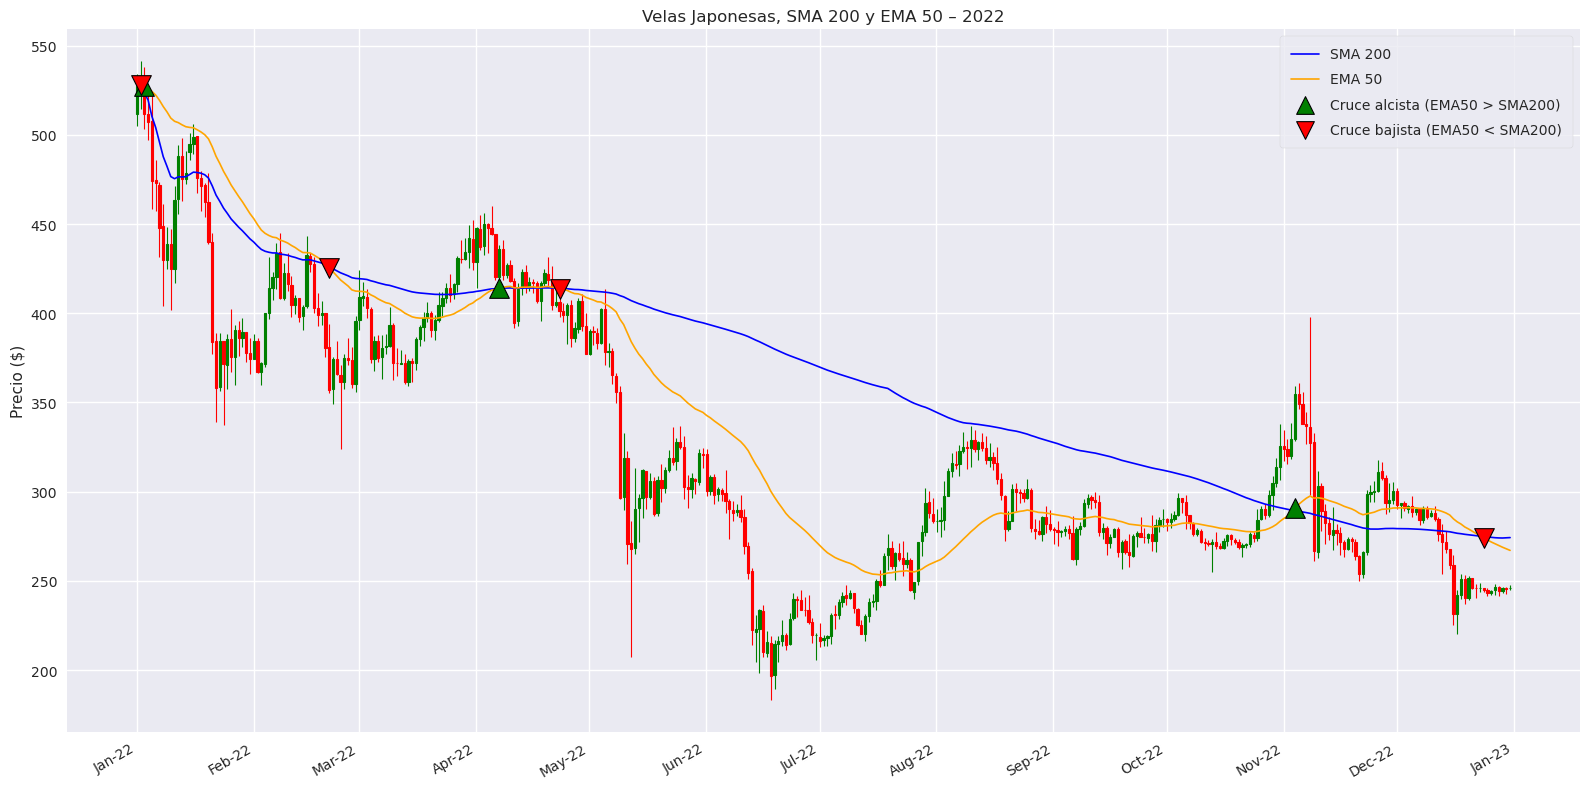

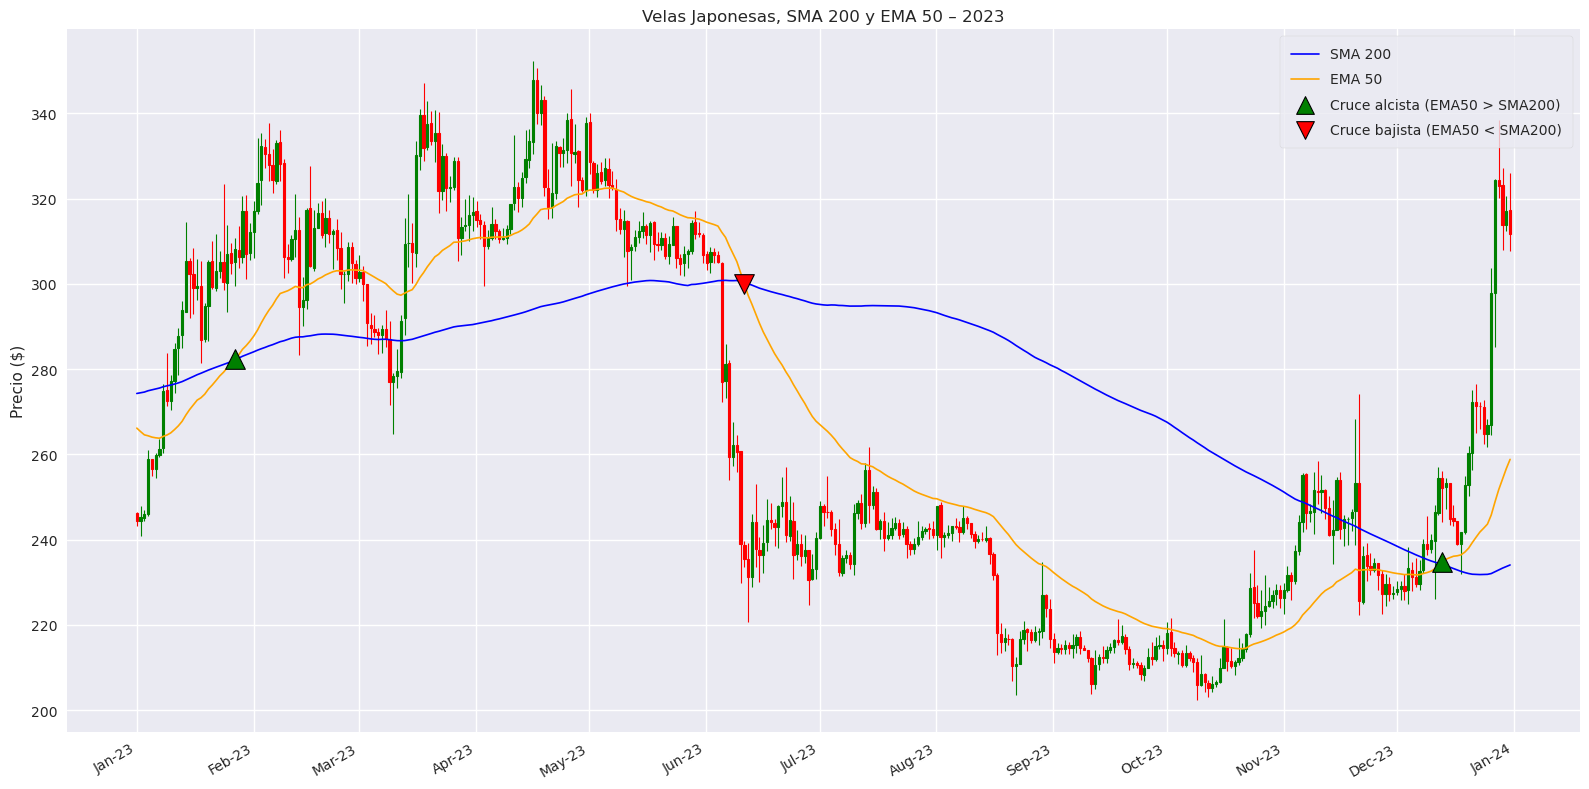

In [ ]:
plot_velas(2022)
plot_velas(2023)
plot_velas(2024)
plot_velas(2025)

## 2) Gráfico 2: Close & Volume
- Close (gráfico de líneas)
- Volume (gráfico de barras)

In [53]:
import matplotlib.pyplot as plt

def plot_close_volume(year_sel: int):
    pdf = get_data_year_pandas(year_sel)  # Spark ya filtra y calcula

    if pdf.empty:
        print(f"No hay datos para el año {year_sel}")
        return

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Close (línea)
    ax1.plot(pdf.index, pdf["close"], color="tab:blue", label="Close")
    ax1.set_ylabel("Precio BNB", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Volumen (barras, eje secundario)
    ax2 = ax1.twinx()
    ax2.bar(pdf.index, pdf["volume"], color="tab:gray", alpha=0.3, label="Volumen")
    ax2.set_ylabel("Volumen", color="tab:gray")
    ax2.tick_params(axis="y", labelcolor="tab:gray")

    # Leyenda combinada
    lines, labels = ax1.get_legend_handles_labels()
    bars, blabels = ax2.get_legend_handles_labels()
    ax1.legend(lines + bars, labels + blabels, loc="upper left")

    ax1.set_title(f"BNB – Close y Volumen ({year_sel})")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

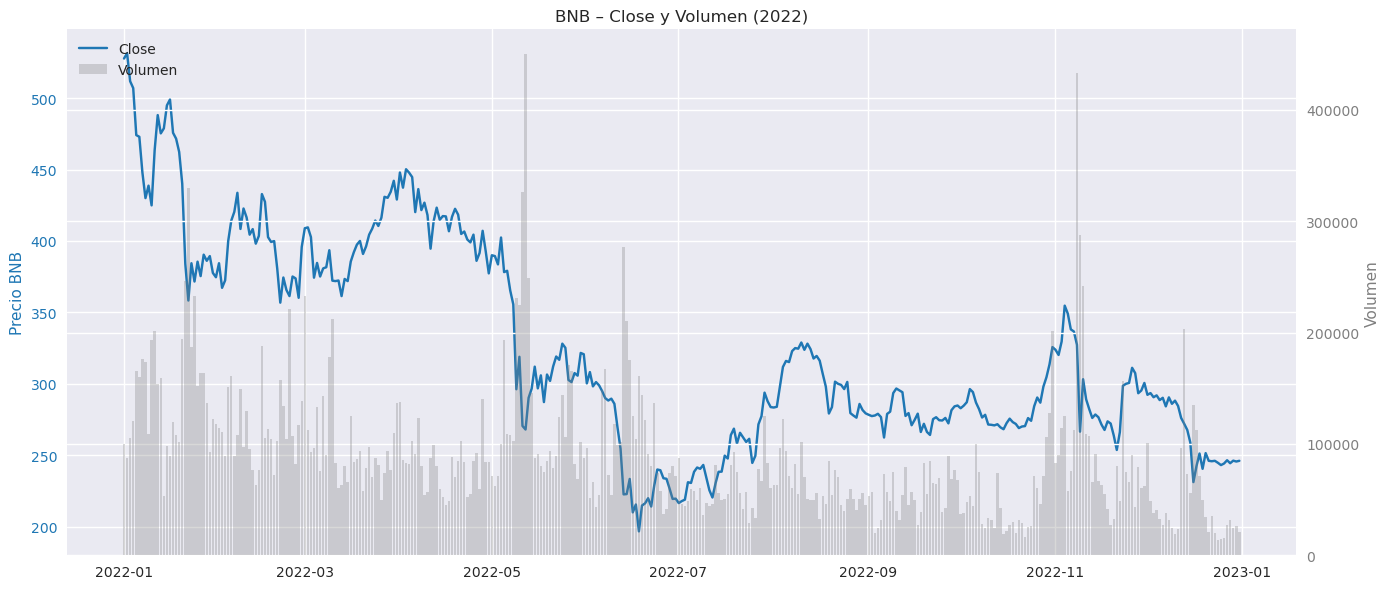

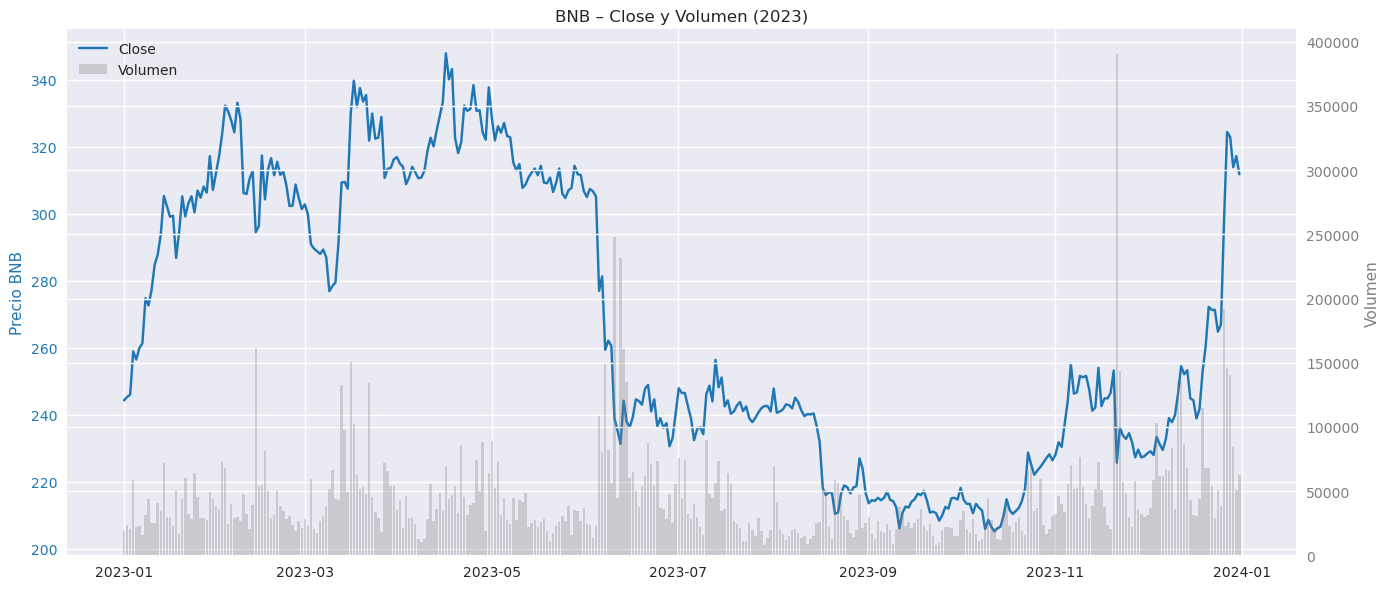

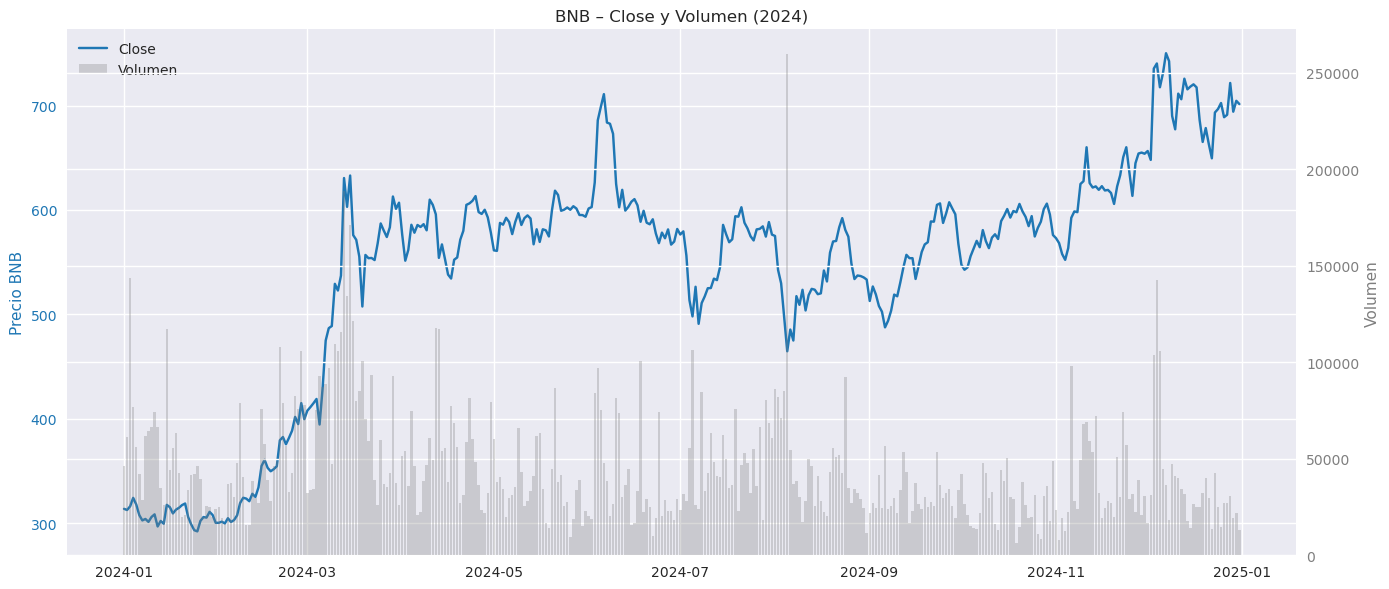

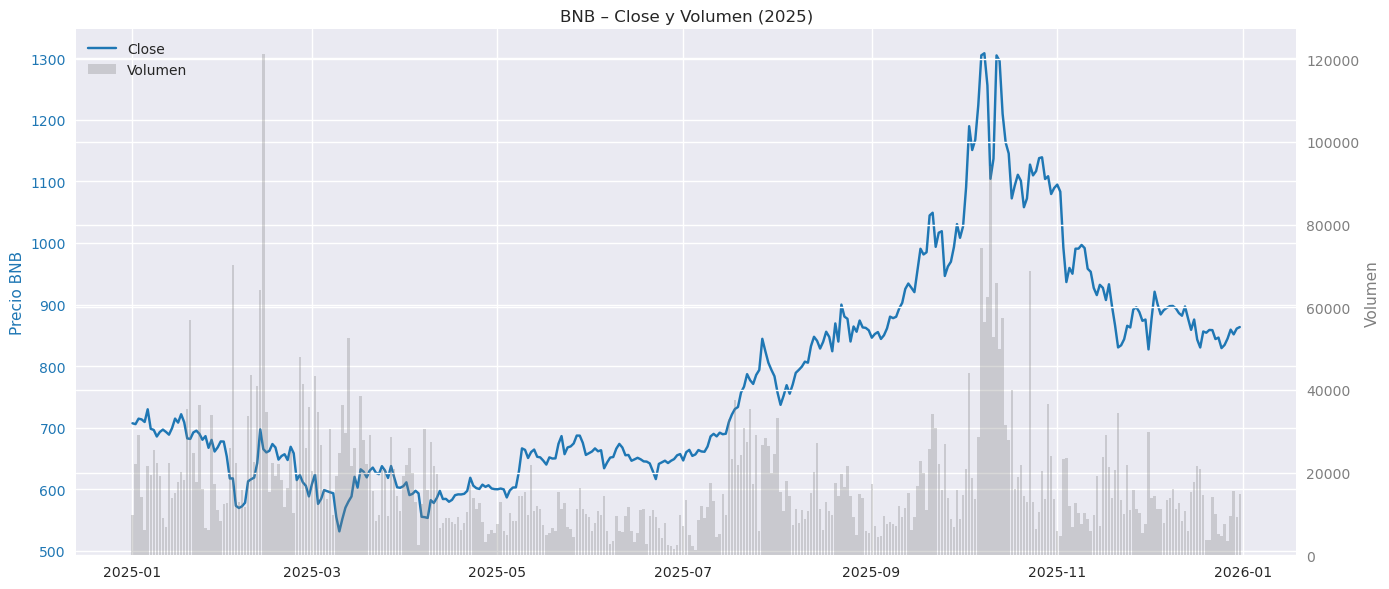

In [54]:
plot_close_volume(2022)
plot_close_volume(2023)
plot_close_volume(2024)
plot_close_volume(2025)

## 3) Gráfico 3: RSI
- RSI con líneas horizontales en: 30 (sobreveta) y 70 (sobrecompra)
- Indicar puntos con RSI < 30 y RSI > 70

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

def plot_rsi(year):
    """
    Filtra los datos de un año específico en Apache Spark y grafica 
    el RSI con Matplotlib, colocando la leyenda fuera del gráfico para evitar solapamientos.
    """
    print(f"Procesando y graficando RSI para el año {year}...")
    
    # 1. SPARK
    df_rsi_spark = df_gold.filter(F.col("year") == year).select("datetime", "RSI_14")
    
    if df_rsi_spark.count() == 0:
        print(f"⚠️ No hay datos disponibles para el año {year}.")
        return

    # 2. PANDAS + MATPLOTLIB
    pdf_rsi = df_rsi_spark.toPandas()
    pdf_rsi['datetime'] = pd.to_datetime(pdf_rsi['datetime'])
    pdf_rsi.set_index('datetime', inplace=True)
    pdf_rsi.sort_index(inplace=True)

    fig, ax = plt.subplots(figsize=(14, 5))

    # Líneas y sombreado
    ax.plot(pdf_rsi.index, pdf_rsi['RSI_14'], label='RSI (14 periodos)', color='purple', linewidth=1.5)
    ax.axhline(70, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Límite Sobrecompra (70)')
    ax.axhline(30, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Límite Sobreventa (30)')
    ax.fill_between(pdf_rsi.index, 30, 70, color='purple', alpha=0.05)

    # FORMATO Y LEYENDA FUERA DEL GRÁFICO
    # pad=40 le da espacio extra arriba para que quepa la leyenda sin chocar con el título
    ax.set_title(f'Gráfico 3: Índice de Fuerza Relativa - RSI ({year})', fontsize=14, pad=40) 
    ax.set_ylabel('Valor RSI', fontsize=12)
    ax.set_ylim(0, 100)
    
    # MAGIA AQUÍ: ncol=3 pone los textos en horizontal, bbox_to_anchor lo saca fuera
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

    ax.grid(True, alpha=0.3)
    fig.autofmt_xdate()
    
    plt.show()

Procesando y graficando RSI para el año 2022...


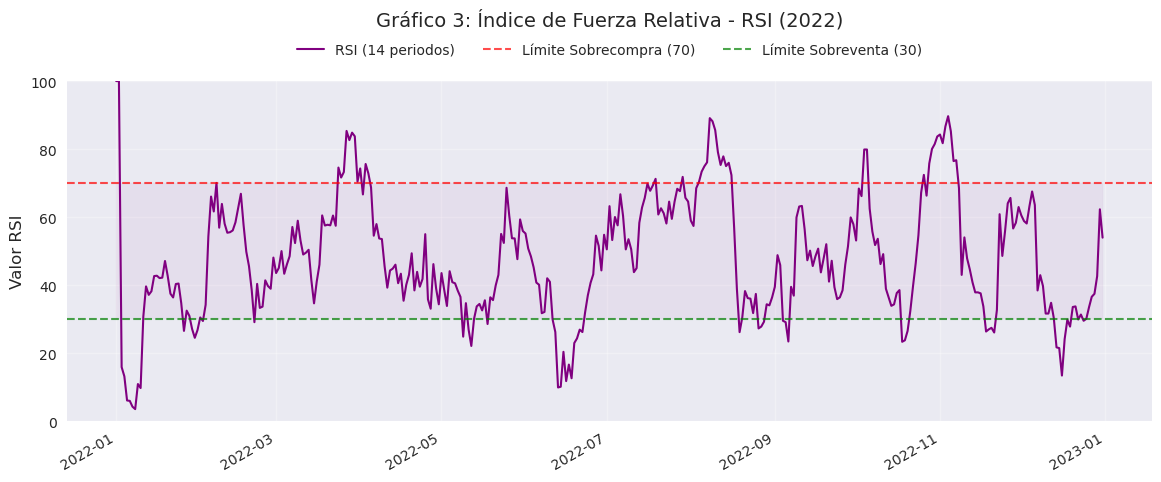

Procesando y graficando RSI para el año 2023...


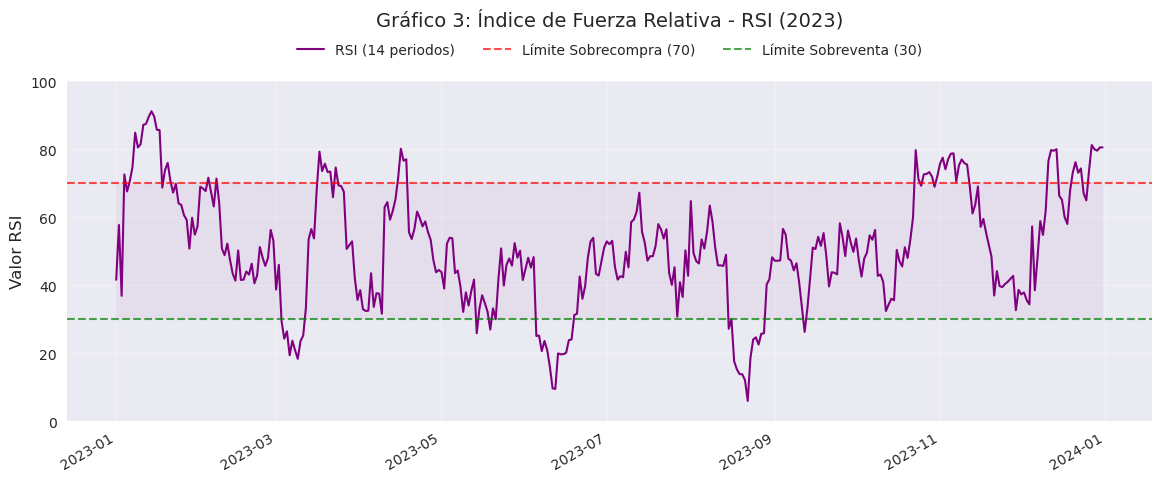

Procesando y graficando RSI para el año 2024...


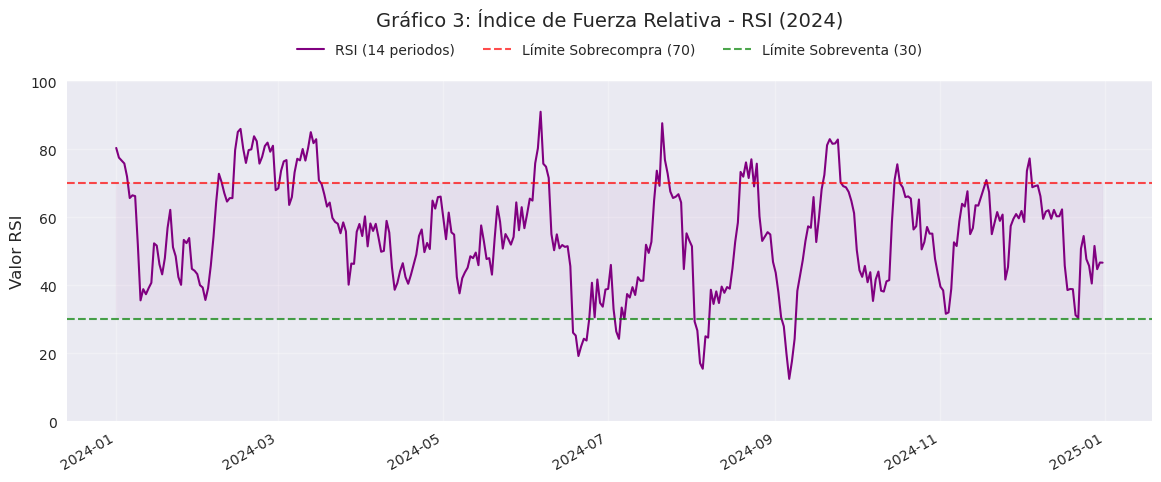

Procesando y graficando RSI para el año 2025...


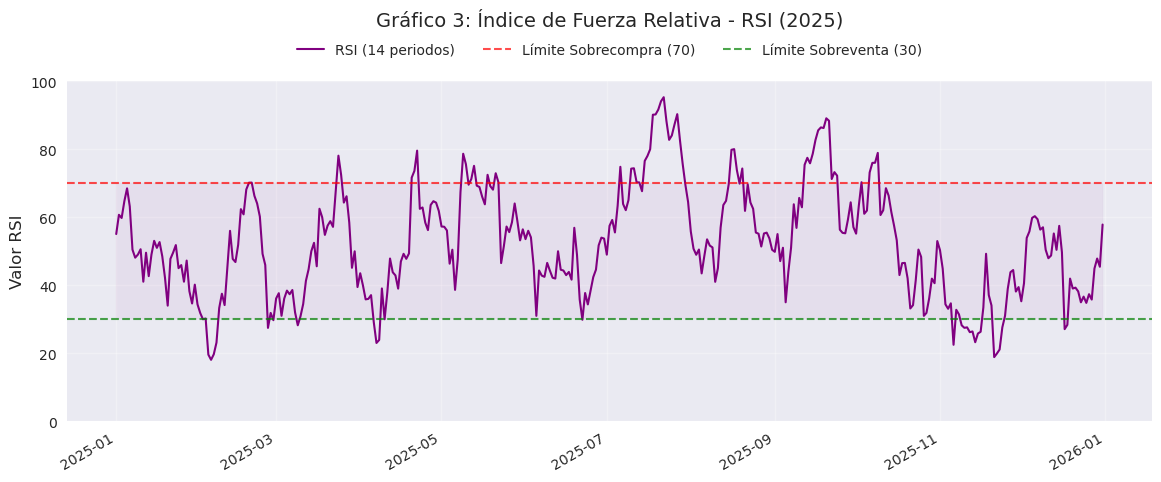

In [50]:
plot_rsi(2022)
plot_rsi(2023)
plot_rsi(2024)
plot_rsi(2025)

## 4) Gráfico 4: MACD

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

def plot_macd(year):
    """
    Filtra los datos de un año específico en Apache Spark y grafica
    únicamente la línea MACD con Matplotlib.
    """
    print(f"Procesando y graficando MACD para el año {year}...")
    
    # -----------------------------------------------------
    # 1. PROCESAMIENTO DISTRIBUIDO (APACHE SPARK)
    # -----------------------------------------------------
    
    # Filtramos la capa Gold por el año solicitado
    df_macd_spark = df_gold.filter(F.col("year") == year) \
                           .select("datetime", "MACD_line")
    
    # Validamos si hay datos para el año solicitado
    if df_macd_spark.count() == 0:
        print(f"⚠️ No hay datos disponibles en la Capa Gold para el año {year}.")
        return

    # -----------------------------------------------------
    # 2. VISUALIZACIÓN EN NODO LOCAL (PANDAS + MATPLOTLIB)
    # -----------------------------------------------------
    
    # Pasamos el resultado ya filtrado a Pandas
    pdf_macd = df_macd_spark.toPandas()

    # Preparamos el índice temporal
    pdf_macd['datetime'] = pd.to_datetime(pdf_macd['datetime'])
    pdf_macd.set_index('datetime', inplace=True)
    pdf_macd.sort_index(inplace=True)

    # Creamos el lienzo
    fig, ax = plt.subplots(figsize=(14, 5))

    # A) Pintamos únicamente la Línea MACD
    ax.plot(pdf_macd.index, pdf_macd['MACD_line'], color='blue', linewidth=1.5)

    # B) Línea cero de referencia (esencial para interpretar el MACD)
    ax.axhline(0, color='gray', linestyle='-', linewidth=1, alpha=0.7)

    # C) Formato final
    ax.set_title(f'Oscilador MACD ({year})', fontsize=14)
    ax.set_ylabel('Valor MACD', fontsize=12)
    ax.grid(True, alpha=0.3)

    fig.autofmt_xdate()
    
    # Mostramos el gráfico
    plt.show()

Procesando y graficando MACD para el año 2022...


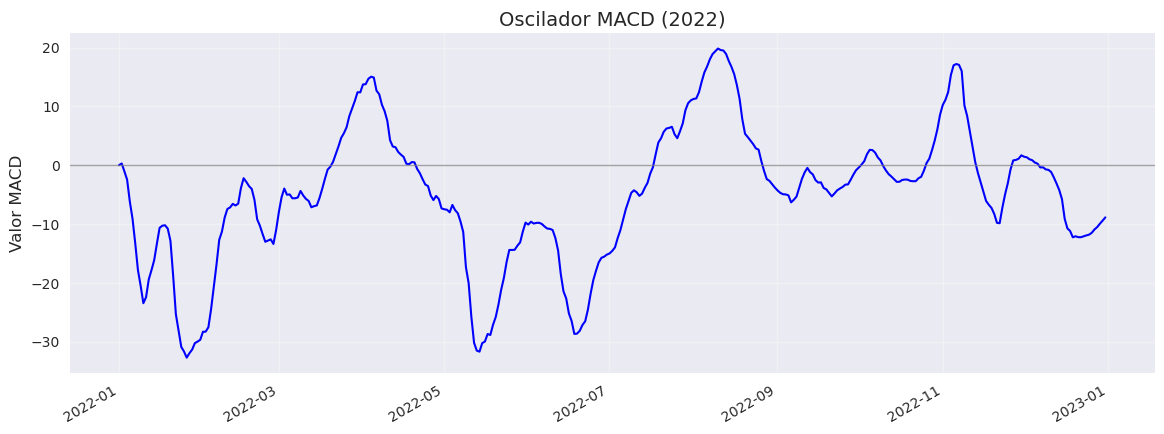

Procesando y graficando MACD para el año 2023...


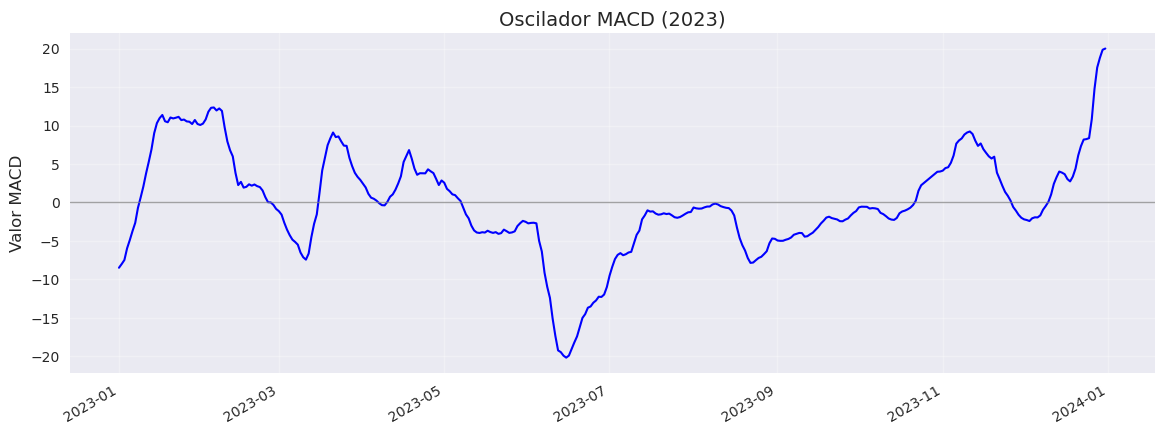

Procesando y graficando MACD para el año 2024...


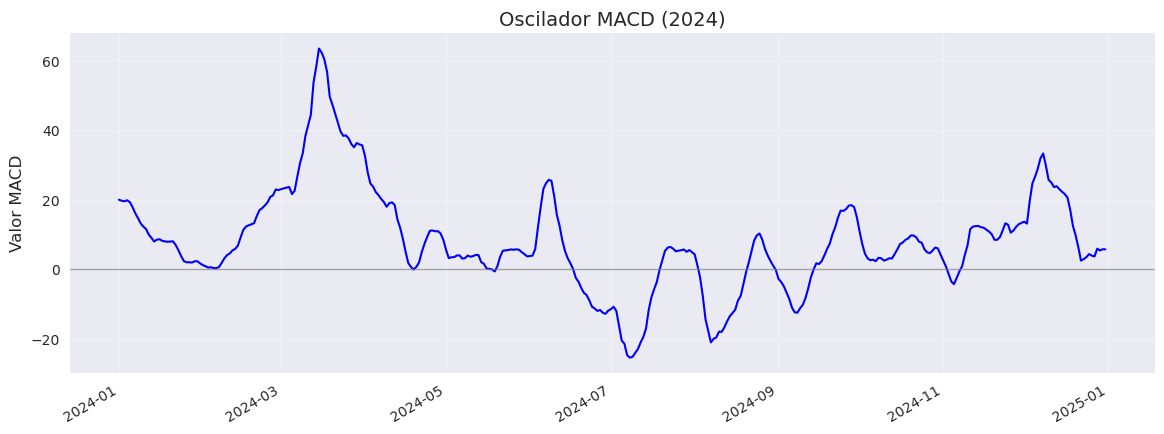

Procesando y graficando MACD para el año 2025...


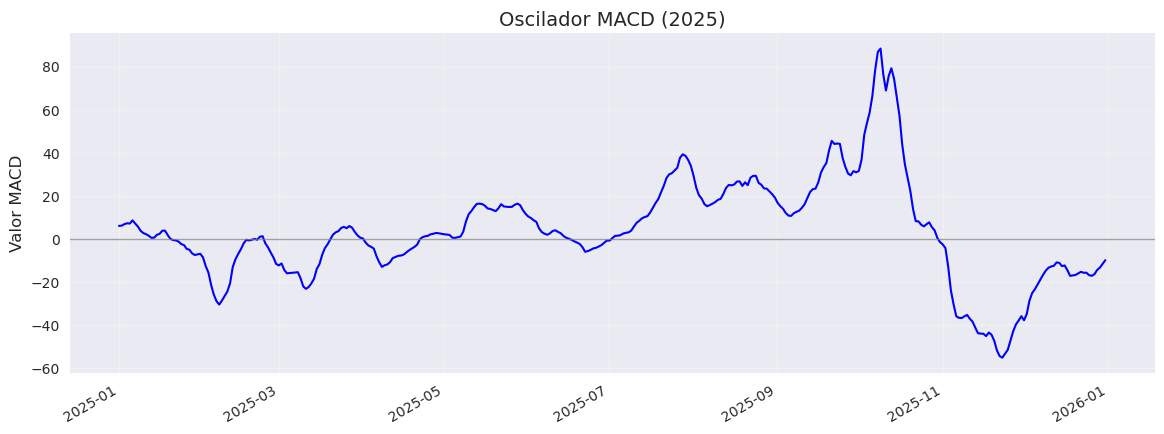

In [38]:
plot_macd(2022)
plot_macd(2023)
plot_macd(2024)
plot_macd(2025)